# Identifying white water on the coast <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Description
This notebook demonstrates how to identify white water on the coast by computing an index based on reflectance in near-infrared and short wave infrared bands.

***

## Getting started

### Load packages

In [1]:
# Import modules
import os
import sys
import datacube 

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import dea_plotting, dea_datahandling

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app='Identifying_white_water')

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Load in Landsat data
Here we use `dea_datahandling.load_ard` to import cloud-free Landsat data from the datacube

In [3]:
# Set up the spatial and temporal bounds of the query
query = {
    'lat': (-28.62, -28.72),
    'lon': (153.60, 153.64),
    'time': ('2017', '2017'),
    'output_crs': 'EPSG:32756',
    'resolution': (-30, 30)
}

# Only load images with more than 90% cloud free pixels
minimum_cloudfree_perc = 0.95

# Load the data
landsat_ds = dea_datahandling.load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
    measurements=['nbart_red', 'nbart_green', 'nbart_blue', 
                  'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'],
    group_by='solar_day',
    mask_pixel_quality=False,
    min_gooddata=minimum_cloudfree_perc,
    **query)

# Keep a record of what pixels are good vs bad (e.g. cloudy or invalid).
# This will be used in the final step to calculate proportions of white
# water observations that account for missing data
good_pixels = ~landsat_ds.nbart_red.isnull()


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 16 out of 64 time steps with at least 95.0% good quality pixels
Loading 16 time steps


### Plot time series of imagery

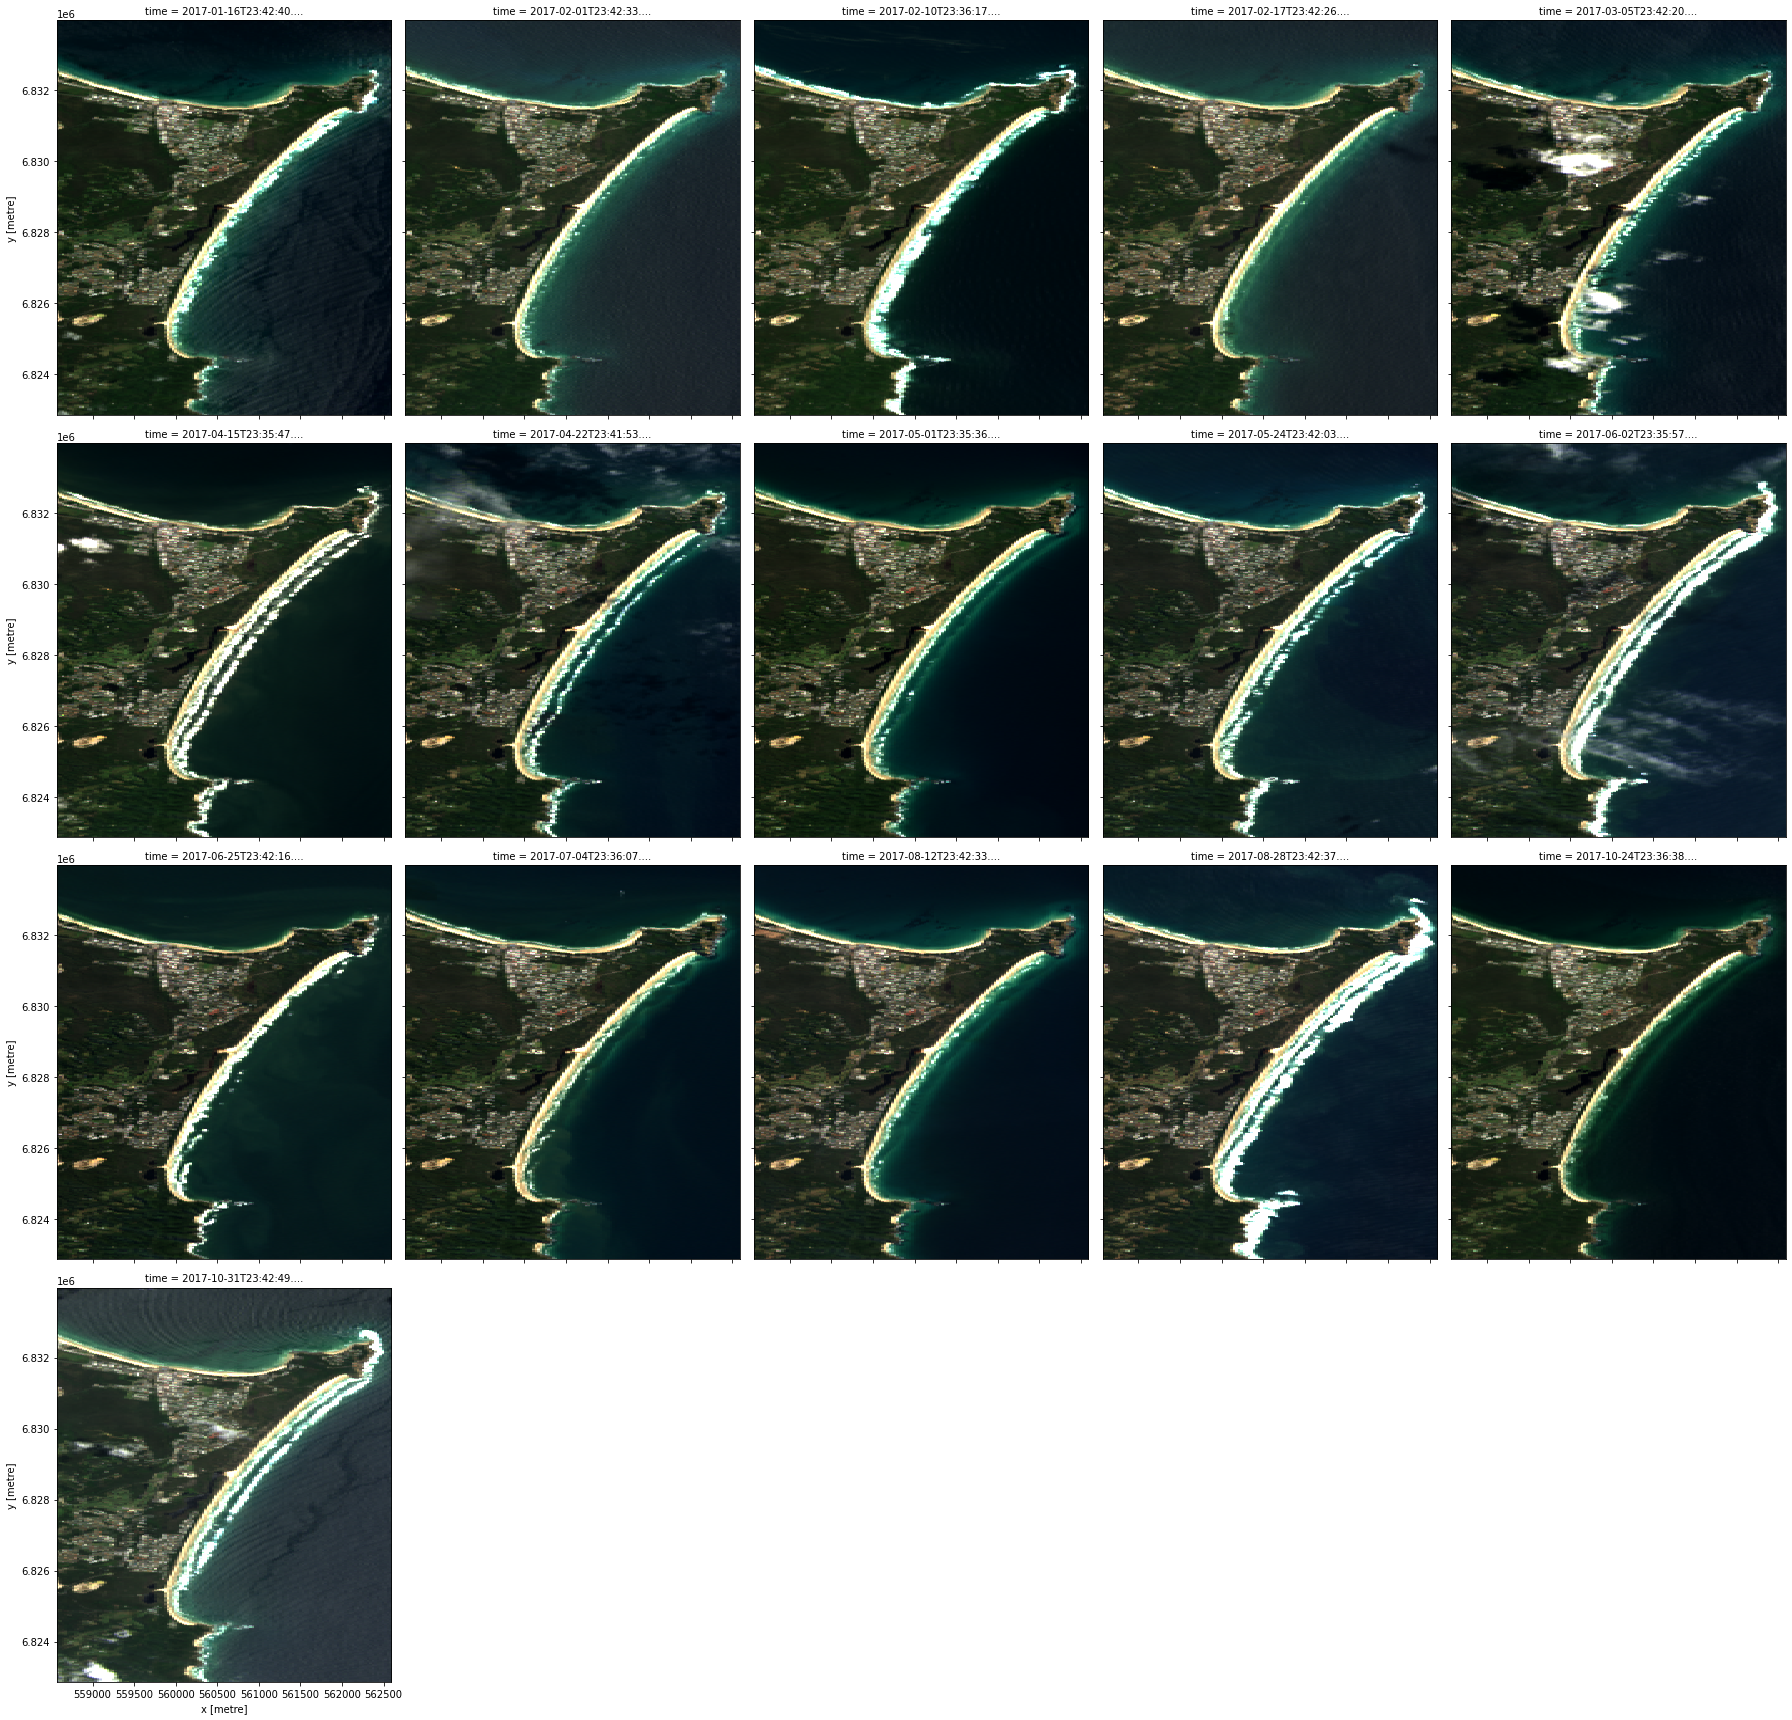

In [4]:
dea_plotting.rgb(landsat_ds, col='time', col_wrap=5, aspect=0.8)

## Remove land pixels

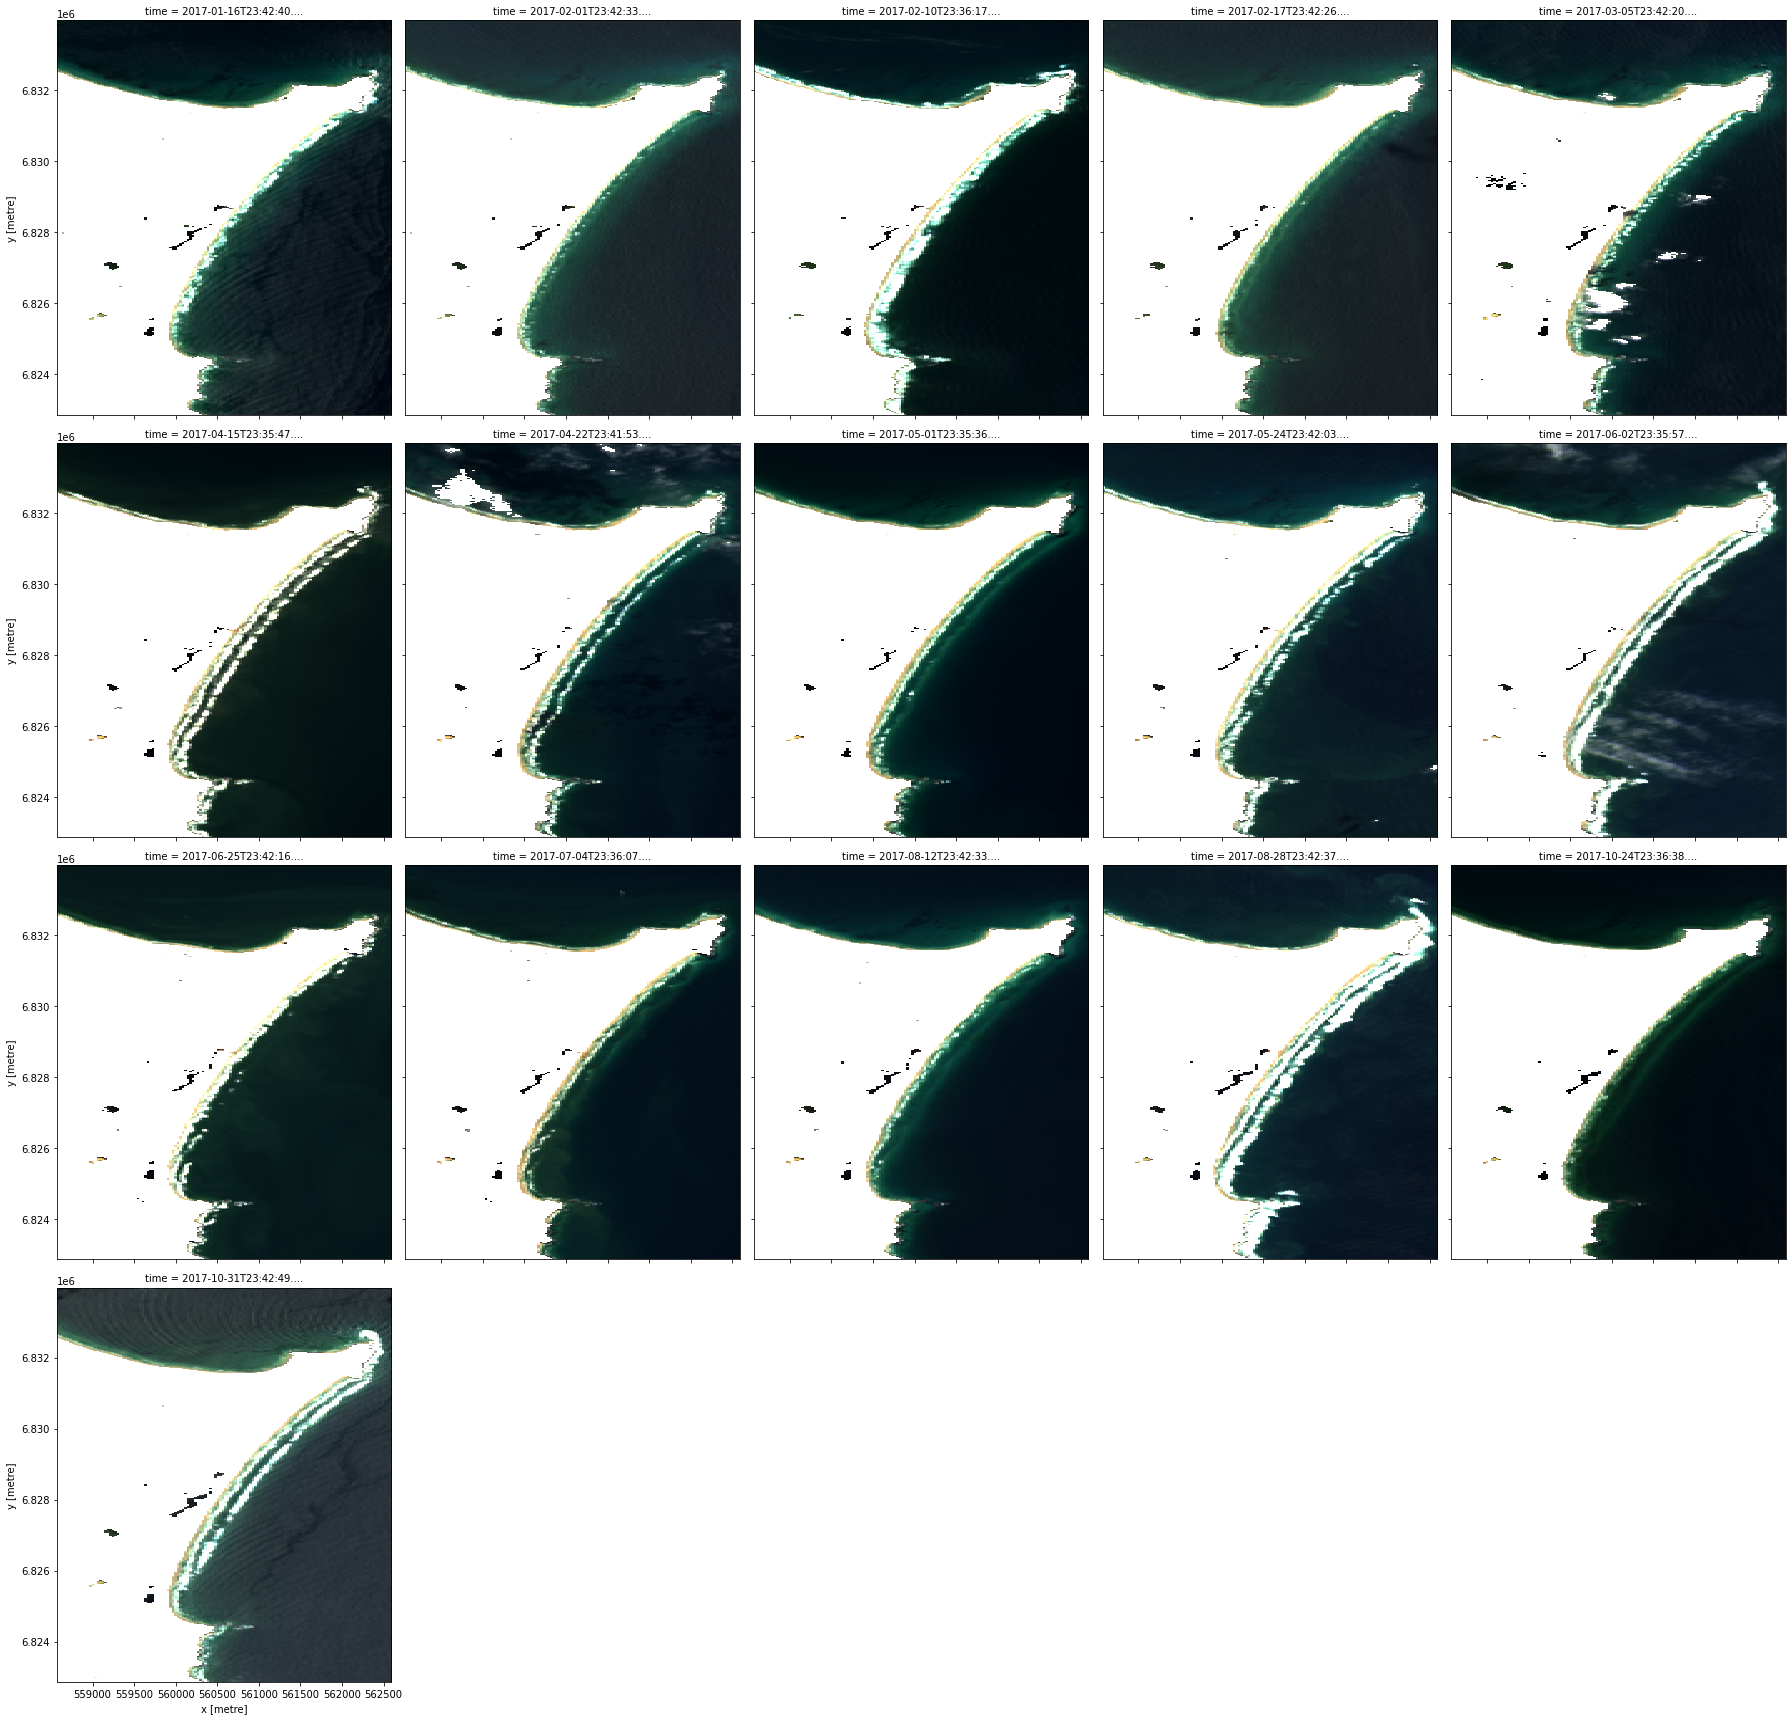

In [5]:
# Identify land pixels
mndwi = (landsat_ds.nbart_green - landsat_ds.nbart_swir_1) / (landsat_ds.nbart_green + landsat_ds.nbart_swir_1)
land_pixels = mndwi > 0

# Apply this mask to our white water index to remove land pixels
landsat_ds = landsat_ds.where(land_pixels)

dea_plotting.rgb(landsat_ds, col='time', col_wrap=5, aspect=0.8)

## Identify white water by brightness
This uses the ratio of near infrared to shortwave radiation (white water reflects more near infrared than shortwave radiation)

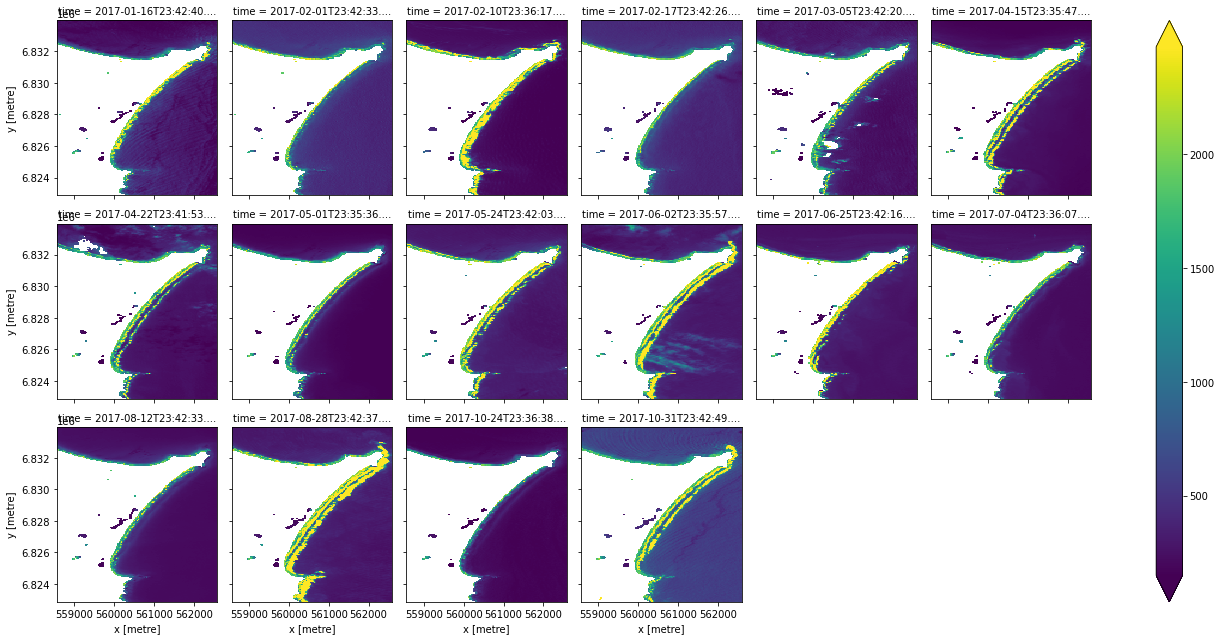

In [6]:
brightness = ((landsat_ds.nbart_red + landsat_ds.nbart_green + landsat_ds.nbart_blue) / 3.0)
brightness.plot(col='time', col_wrap=6, robust=True)

## Apply a threshold to extract white water

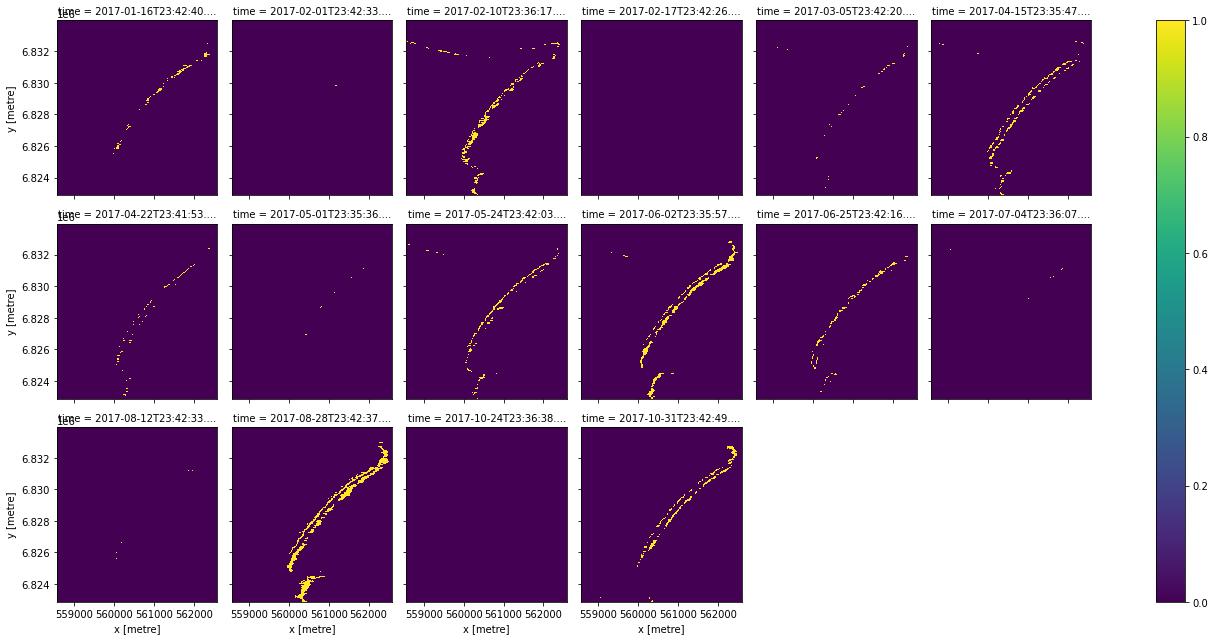

In [7]:
brightness_threshold = 3000

# Apply the threshold value to the NDWWI data to get back a dataset where True = white water
white_water = brightness > brightness_threshold

# Plot
white_water.plot(col='time', col_wrap=6)

## Calculate summary/frequency of white water
Now we have a dataset of possible white water, we can summarise it through time. Here we take the mean of all good/non-cloudy pixels through time - this will give us a proportion indicating how often each pixel was observed as white water throughout the time series:

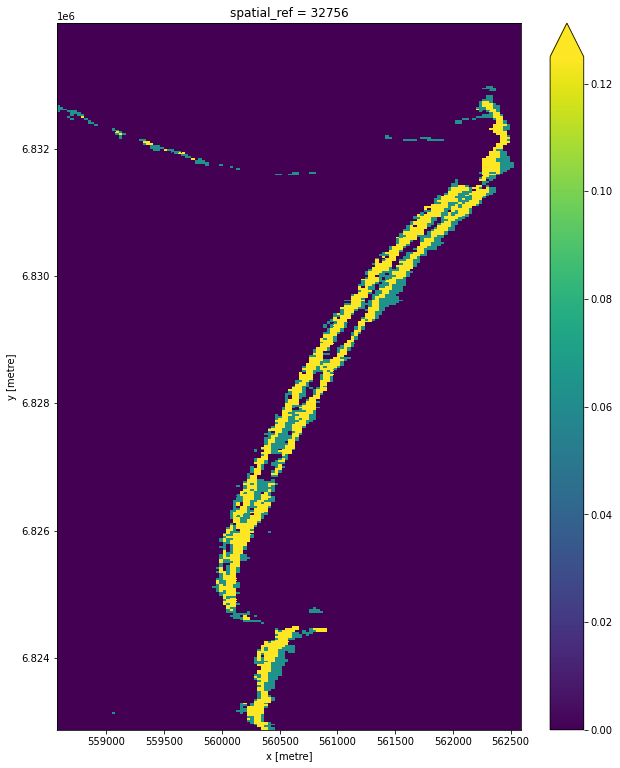

In [8]:
white_water.where(good_pixels).mean(dim='time').plot(size=13, robust=True, aspect=0.8)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2019

**Compatible datacube version:** 

In [9]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

<script src="https://embed.github.com/view/geojson/benbalter/dc-wifi-social/master/bars.geojson"></script>
